<a href="https://colab.research.google.com/github/bhanuchaddha/The-Ai-Handbook/blob/main/2-Tutorials/RAG/Database/Agentic_RAG_With_MongoDB_and_LamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: RAG with MongoDB and LlamaIndex: A Comprehensive Tutorial

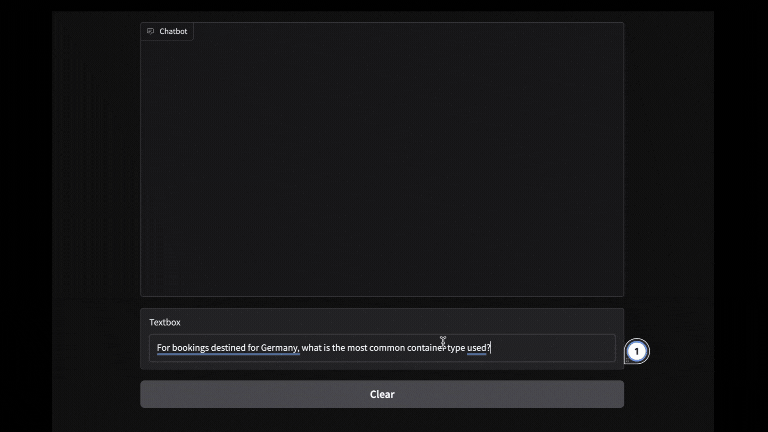



## Introduction

Retrieval Augmented Generation (RAG) has emerged as a powerful technique in the realm of natural language processing (NLP). It enhances the capabilities of language models by allowing them to access and incorporate external knowledge during text generation. This tutorial focuses on implementing an advanced form of RAG called "Agentic RAG" using the robust combination of MongoDB, a leading NoSQL document database, and LlamaIndex, a powerful framework designed for indexing and querying data for LLM applications.

In a typical RAG setup, a system retrieves relevant information from a knowledge base (e.g., a vector database) to provide context to a large language model (LLM). This allows the LLM to generate more informed and accurate responses. Agentic RAG takes this a step further by introducing "agents" – specialized components that can perform specific actions or interact with different tools to gather and process information more effectively.

## Why MongoDB and LlamaIndex?

MongoDB: MongoDB's flexible document model and powerful querying capabilities make it a great choice for storing and managing the diverse data that RAG systems often rely on. Its scalability and performance are crucial when dealing with large datasets.

LlamaIndex: LlamaIndex simplifies the process of connecting LLMs with external data sources. It provides abstractions for data ingestion, indexing (including vector embeddings), and building sophisticated query engines, which are essential for creating effective RAG systems.

## In this tutorial, we will:

* Set up a MongoDB database to store our knowledge base.

* Use LlamaIndex to ingest data into MongoDB and create a vector index for efficient retrieval.

* Implement a basic query engine that leverages the vector index to find relevant documents.

* Introduce the concept of "Agentic RAG" and demonstrate how to build a simple agent-based system.

* Showcase how the agent can interact with the query engine and an LLM to generate context-aware responses.

## Prerequisites

Before starting, ensure you have the following:

* Basic understanding of Python.

* Familiarity with language models and vector embeddings (helpful but not mandatory).

* A MongoDB database instance (you can use MongoDB Atlas for a free cloud-based option).

* An OpenAI API key (for using the OpenAI language model).


Let's dive in!

# Installation and Setup

In [ ]:
pip install --quiet --upgrade llama-index llama-index-vector-stores-mongodb llama-index-embeddings-openai pymongo faker load_dotenv

In [ ]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')
os.environ['MONGO_CONNECTION_STRING']=userdata.get('MONGO_CONNECTION_STRING')

**Explanation:**

*   **`pip install ...`:** This command installs the necessary Python packages for this project. Let's break down each package:
    *   `llama-index`: The core library for building the RAG system. It provides tools for data ingestion, indexing, and querying.
    *   `llama-index-vector-stores-mongodb`: A LlamaIndex integration that enables using MongoDB as a vector store.
    *   `llama-index-embeddings-openai`: A LlamaIndex integration for using OpenAI's embedding models to generate vector embeddings.
    *   `pymongo`: The official Python driver for MongoDB, allowing interaction with MongoDB databases.
    *   `faker`: A library for generating synthetic data, which will be used to create sample booking records.
    *   `load_dotenv`: A library for loading environment variables from a `.env` file (though in this Colab example, it seems environment variables are handled differently).
    *   `--quiet`: Suppresses verbose output during installation.
    *   `--upgrade`: Ensures that the latest versions of the packages are installed.

*   **`from google.colab import userdata`**: This line imports the `userdata` module from the `google.colab` library. This module is specific to Google Colab and is used to securely access user data, such as API keys and other secrets, that are stored within the Colab environment.


**References:**

*   LlamaIndex Documentation: [https://docs.llamaindex.ai/en/stable/](https://docs.llamaindex.ai/en/stable/)
*   PyMongo Documentation: [https://pymongo.readthedocs.io/en/stable/](https://pymongo.readthedocs.io/en/stable/)
*   OpenAI Python Library: [https://github.com/openai/openai-python](https://github.com/openai/openai-python)
*   Faker Documentation: [https://faker.readthedocs.io/en/master/](https://faker.readthedocs.io/en/master/)

# Generate Data

In [ ]:
db_name = "shipping_company"

In [ ]:
from pymongo import MongoClient
from faker import Faker
import random
from datetime import datetime, timedelta
import uuid
from dotenv import load_dotenv


# Load environment variables from .env
load_dotenv()

# Read MONGO_CONNECTION_STRING from environment, fallback to a default if not found
MONGO_URL = os.getenv("MONGO_CONNECTION_STRING", "mongodb://localhost:27017")

# MongoDB Connection
client = MongoClient(MONGO_URL)
db = client[db_name]
bookings_collection = db["bookings"]

# Faker Initialization
fake = Faker()

# Sample Data (for variety)
cities = ["Los Angeles", "New York", "Shanghai", "Rotterdam", "Singapore", "Dubai", "Hamburg", "Antwerp", "Busan", "Hong Kong"]
countries = ["USA","USA", "China", "Netherlands", "Singapore", "UAE", "Germany", "Belgium", "South Korea", "Hong Kong"]
ports = ["Port of Los Angeles", "Port of New York", "Port of Shanghai", "Port of Rotterdam", "Port of Singapore", "Port of Jebel Ali", "Port of Hamburg", "Port of Antwerp", "Port of Busan", "Port of Hong Kong"]
booking_channels = ["Website", "Phone", "Email", "Agent"]
booking_statuses = ["Pending", "Confirmed", "In Transit", "Delivered", "Cancelled"]
vessel_names = ["Ever Given", "Maersk Mc-Kinney Moller", "MSC Oscar", "HMM Algeciras", "COSCO Shipping Universe", "OOCL Hong Kong", "CMA CGM Antoine de Saint Exupery", "APL Raffles", "Yang Ming Witness", "ONE Innovation"]
container_types = ["20ft Standard", "40ft Standard", "40ft High Cube", "45ft High Cube"]

def generate_booking():
    customer_id = str(uuid.uuid4())
    origin_city = random.choice(cities)
    destination_city = random.choice(cities)
    origin_country = countries[cities.index(origin_city)]
    destination_country = countries[cities.index(destination_city)]
    origin_port = ports[cities.index(origin_city)]
    destination_port = ports[cities.index(destination_city)]

    booking = {
        "bookingId": str(uuid.uuid4()),
        "customer": {
            "customerId": customer_id,
            "name": fake.name(),
            "email": fake.email(),
            "phone": fake.phone_number()
        },
        "origin": {
            "city": origin_city,
            "country": origin_country,
            "port": origin_port
        },
        "destination": {
            "city": destination_city,
            "country": destination_country,
            "port": destination_port
        },
        "parties": [
            {
                "type": "shipper",
                "name": fake.company(),
                "address": fake.address()
            },
            {
                "type": "consignee",
                "name": fake.company(),
                "address": fake.address()
            }
        ],
        "bookingChannel": random.choice(booking_channels),
        "bookingStatus": random.choice(booking_statuses),
        "priceQuotation": {
            "currency": "USD",
            "amount": round(random.uniform(1000, 5000), 2),
            "validUntil": fake.date_time_between(start_date="now", end_date="+30d", tzinfo=None)
        },
        "vesselInformation": {
            "name": random.choice(vessel_names),
            "imoNumber": str(random.randint(9000000, 9999999)),
            "voyageNumber": f"{random.randint(100, 999)}{random.choice(['E', 'W'])}"
        },
        "container": {
            "containerNumber": f"{random.choice(['MSCU', 'MAEU', 'APLU', 'OOLU'])}{random.randint(1000000, 9999999)}",
            "type": random.choice(container_types),
            "sealNumber": f"SEAL{random.randint(10000, 99999)}"
        },
        "routeInformation": {
            "departureDate": fake.date_time_between(start_date="-30d", end_date="+30d", tzinfo=None),
            "arrivalDate": fake.date_time_between(start_date="+30d", end_date="+90d", tzinfo=None),
            "transitPorts": random.sample(ports, random.randint(0, 2))  # 0 to 2 transit ports
        },
        "priceInformation": {
            "freightCharges": round(random.uniform(800, 4000), 2),
            "originCharges": round(random.uniform(50, 300), 2),
            "destinationCharges": round(random.uniform(50, 300), 2),
            "totalCharges": 0,  # Calculated below
            "currency": "USD"
        },
        "createdAt": fake.date_time_between(start_date="-60d", end_date="now", tzinfo=None),
        "updatedAt": datetime.now()
    }

    # Calculate total charges
    booking["priceInformation"]["totalCharges"] = booking["priceInformation"]["freightCharges"] + \
                                                  booking["priceInformation"]["originCharges"] + \
                                                  booking["priceInformation"]["destinationCharges"]

    return booking
## Enable below to generate data.
# Generate and Insert Data
# bookings = []
# for _ in range(1000):
#     bookings.append(generate_booking())

# bookings_collection.insert_many(bookings)

print("Successfully inserted 1000 booking records!")

Successfully inserted 1000 booking records!


**Explanation:**


**In essence, this section generates 1000 fake booking records with realistic data and stores them in a MongoDB database.**

# Configure LlamaIndex

In [ ]:
import getpass, os, pymongo, pprint
from pymongo.operations import SearchIndexModel
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, StorageContext
from llama_index.core.settings import Settings
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.vector_stores import MetadataFilter, MetadataFilters, ExactMatchFilter, FilterOperator
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.vector_stores.mongodb import MongoDBAtlasVectorSearch

## Configure LlamaIndex settings.
Run the following code to configure settings that are specific to LlamaIndex. These settings specify the following:

OpenAI as the LLM used by your application to answer questions on your data.

text-embedding-ada-002 as the embedding model used by your application to generate vector embeddings from your data.

Chunk size and overlap to customize how LlamaIndex partitions your data for storage.

In [ ]:
llm= OpenAI()

In [ ]:
Settings.llm = OpenAI()
Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
Settings.chunk_size = 100
Settings.chunk_overlap = 10

**Explanation:**


*   **`llm = OpenAI()`:** This line initializes the `llm` variable with an instance of the `OpenAI` class. This sets the default large language model (LLM) to be used by LlamaIndex to OpenAI's default model (likely GPT-3.5 Turbo or a similar model).

*   **`Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")`:** This line configures the embedding model that LlamaIndex will use to generate vector embeddings.
    *   `OpenAIEmbedding`: Specifies that an OpenAI embedding model will be used.
    *   `model="text-embedding-ada-002"`: Sets the specific OpenAI embedding model to "text-embedding-ada-002". This is a widely used and cost-effective embedding model.
*   **`Settings.chunk_size = 100`:** This sets the chunk size for text splitting. When LlamaIndex ingests documents, it breaks them down into smaller chunks. This line sets the chunk size to 100 tokens (approximately 100 words, but the exact number can vary depending on the tokenizer).
*   **`Settings.chunk_overlap = 10`:** This sets the chunk overlap to 10 tokens. This means that consecutive chunks will have an overlap of 10 tokens, which can help maintain context when querying.

**In summary, this section configures LlamaIndex to use OpenAI's language model and embedding model, and it sets parameters for how the text data should be chunked during indexing.**

# Data Loading and Indexing

In [ ]:
mongo_client = pymongo.MongoClient(os.environ['MONGO_CONNECTION_STRING'])
db = mongo_client[db_name]
collections = db.list_collection_names()
# collections.remove("vectors")

In [ ]:
from llama_index.core import Document


In [ ]:
vector_col="vectors"
index_name="vector_index"

In [ ]:
# Instantiate the vector store for each collection
shipping_vector_store = MongoDBAtlasVectorSearch(
    mongo_client,
    db_name=db_name,
    collection_name=vector_col,
    vector_index_name=index_name
)

In [ ]:
for collection_name in collections:
    collection = db[collection_name]
    raw_documents = list(collection.find({}))
    # Convert raw documents (dictionaries) to Document objects
    documents = [Document(text=str(doc)) for doc in raw_documents]

    vector_store_context = StorageContext.from_defaults(vector_store=shipping_vector_store)
    # Convert documents to vector embeddings and store them
    vector_store_index = VectorStoreIndex.from_documents(
        documents, storage_context=vector_store_context, show_progress=True
)

Parsing nodes:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/429 [00:00<?, ?it/s]

In [ ]:
db = mongo_client[db_name]
collection = db[vector_col]

# Create your index model, then create the search index
search_index_model = SearchIndexModel(
  definition={
    "fields": [
      {
        "type": "vector",
        "path": "embedding",
        "numDimensions": 1536,
        "similarity": "cosine"
      },
      {
        "type": "filter",
        "path": "metadata.page_label"
      }
    ]
  },
  name="vector_index",
  type="vectorSearch",
)

collection.create_search_index(model=search_index_model)



'vector_index'

**Explanation:**


*   **`shipping_vector_store = MongoDBAtlasVectorSearch(...)`:** This line creates an instance of `MongoDBAtlasVectorSearch`, which is a LlamaIndex class that represents a vector store backed by MongoDB Atlas.
    *   `mongo_client`: The MongoDB client object used to connect to the database.
    *   `db_name`: The name of the database.
    *   `collection_name`: The name of the collection where vectors will be stored ("vectors").
    *   `index_name`: The name of the vector index ("vector\_index").
*   **`for collection_name in collections:`:** This loop iterates through each collection name in the list of collections retrieved earlier.
    *   **`documents = [Document(text=str(doc)) for doc in raw_documents]`:** This is a list comprehension that converts each raw document (a dictionary) into a LlamaIndex `Document` object. The `text` of the `Document` is set to the string representation of the raw document.
    *   **`vector_store_context = StorageContext.from_defaults(vector_store=shipping_vector_store)`:** Creates a `StorageContext` object, which manages how data is stored in LlamaIndex. It's configured to use the `shipping_vector_store` (the MongoDB vector store) that was created earlier.
    *   **`vector_store_index = VectorStoreIndex.from_documents(...)`:** This is the core indexing step. It creates a `VectorStoreIndex` from the `Document` objects.
        *   `documents`: The list of `Document` objects to be indexed.
        *   `storage_context`: The `StorageContext` that specifies where to store the index data (in this case, the MongoDB vector store).
        *   `show_progress=True`: Displays a progress bar during the indexing process.

*   **`search_index_model = SearchIndexModel(...)`:** This defines the structure of the vector search index that will be created in MongoDB.
    *   **`definition`:** Specifies the fields to be indexed and their types.
        *   **`type: "vector"`:** Indicates a vector field for storing embeddings.
            *   `path`: The path to the embedding field within the document (it will be named "embedding").
            *   `numDimensions`: The dimensionality of the embeddings (1536, which is the dimensionality of the "text-embedding-ada-002" model).
            *   `similarity`: The similarity function to use for vector search ("cosine" similarity).
        *   **`type: "filter"`:** Indicates a filterable field.
            *   `path`: The path to the filterable field ("metadata.page\_label").
    *   **`name: "vector_index"`:** The name of the index.
    *   **`type: "vectorSearch"`:** Specifies that this is a vector search index.
*   **`collection.create_search_index(model=search_index_model)`:** This line creates the vector search index in MongoDB based on the defined `search_index_model`.

**In essence, this section loads the data from MongoDB, converts it into LlamaIndex `Document` objects, generates vector embeddings for the documents using the configured embedding model, and stores the embeddings in a MongoDB collection along with a vector search index for efficient querying.**

# Search

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
index = VectorStoreIndex.from_vector_store(shipping_vector_store)
query_engine = index.as_query_engine(similarity_top_k=100, llm=llm)


**Explanation:**

*   **`from llama_index.core import VectorStoreIndex ...`:** These lines import necessary classes from LlamaIndex:
    *   `VectorStoreIndex`: For creating an index from a vector store.
    *   `QueryEngineTool`, `ToolMetadata`: For creating tools that can be used by agents (not directly used in this section but relevant for the Agentic RAG concept).
*   **`index = VectorStoreIndex.from_vector_store(shipping_vector_store)`:** This line creates a `VectorStoreIndex` object from the `shipping_vector_store` (the MongoDB vector store) that was created earlier. This index allows you to query the data using vector search.
*   **`query_engine = index.as_query_engine(similarity_top_k=100, llm=llm)`:** This line creates a query engine from the index.
    *   `similarity_top_k=100`: Specifies that the query engine should retrieve the top 100 most similar documents based on vector similarity.
    *   `llm=llm`: Sets the language model to be used by the query engine to the `llm` object (which was configured earlier to be an OpenAI model).


In [ ]:
query_text = "how many booking are there for Lisa Peterson?. give me the infomation about those bookings"
response = query_engine.query(query_text)
print(response)



There are two bookings for Lisa Peterson. The first booking has the consignee name 'Peters Group' with the address '04551 Jessica Squares Suite 692, Port Nicole, MN 04965' and the booking channel is 'Phone'. The second booking has the consignee name 'Cooke-Bass' with the address '117 Timothy Island, Jennabury, WA 59527' and the booking channel is 'Phone'.


In [ ]:
query_text = "How many customers do i have? List the customers"
response = query_engine.query(query_text)
print(response)

Empty Response


In [ ]:
query_text = "Give me markdown table for booking, customer, cost for all the booking in or out of China"
response = query_engine.query(query_text)
print(response)

Empty Response


In [ ]:
query_text = "What is the average total cost of shipments originating from ports in the USA and destined for ports in Asia, and how does this compare to the average cost of shipments between European ports? Provide a breakdown by destination port."
response = query_engine.query(query_text)
print(response)

Empty Response


**Conclusion**

This tutorial provided a comprehensive guide to building an RAG system using MongoDB and LlamaIndex. We covered the essential steps, from setting up the environment and generating data to indexing the data in MongoDB and creating a query engine for semantic search.

By leveraging the power of MongoDB's flexible data model and LlamaIndex's indexing and querying capabilities, you can create sophisticated RAG systems that can answer complex questions based on your data. The introduction of "agents" further enhances the system's capabilities, allowing for more dynamic and intelligent interactions with external knowledge sources.

As you continue to explore RAG, consider experimenting with different agent architectures, tools, and query engine configurations to build even more powerful and adaptable LLM applications. The combination of MongoDB and LlamaIndex provides a solid foundation for your journey into the exciting world of advanced RAG systems.

# Running code with UI

In [ ]:
!pip install gradio

# Query Interface for MongoDB data

In [ ]:
import gradio as gr

# Define the query function for Gradio
def query_function(query):
    response = query_engine.query(query)
    return response

# Create the Gradio interface
iface = gr.Interface(
    fn=query_function,
    inputs=gr.Textbox(placeholder="Enter your query here..."),
    outputs="text",
    title="Vector Store Query Interface",
    description="Ask a question and get an answer from the vector store.",
)

# Launch the interface (share=True creates a temporary public URL)
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f450ec7a02e99b8554.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Chat Interface for MongoDB data

In [ ]:
# Corrected respond function
def respond(message, chat_history):
    bot_message = query_engine.query(message)
    chat_history.append([message, str(bot_message)])  # Append as a list [user_msg, bot_msg]
    return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot()
    msg = gr.Textbox()
    clear = gr.Button("Clear")

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: [], None, chatbot, queue=False)  # Clear chat history

demo.launch(share=True)

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:242: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e927cf95a9cbf15879.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Sample Questions


1.   For bookings destined for Germany, what is the most common container type used?
2.   How many bookings have a total charge greater than $2500 and were created in the last two weeks?
3. which customer made maximum number of booking?
4. The most busy port based on the provided context information is the Port of Busan in South Korea. There are a total of 36 bookings originating from the Port of Busan.
5. Identify any customers who have had more than 2 bookings with a 'Cancelled' status. For these customers, what is the average value of their 'Confirmed' bookings?
6. List all bookings originating from the Port of Los Angeles. Output should be Markdown with bookingID, Source, Destination, Customer and Value

